In [123]:
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
from math import ceil, sqrt
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import sys
sys.path.append('../')
from data.datasets import SSWEDataset
from neuralop.utils import count_model_params
from matplotlib import pyplot as plt
import cmcrameri.cm as cmc
from timeit import default_timer
from utils.losses import EnergyScore, KernelScore, VariogramScore, LpLoss, SphericalL2Loss
from models.fno import FNO, SFNO
from models.pfno import PFNO, PSFNO
from models.pfno import PNO_Wrapper
from models.laplace import LA_Wrapper
from models.mcdropout import generate_mcd_samples


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

plt.rcParams['image.cmap'] = "cmc.vik"

In [124]:
batch_size = 50
n_samples = 50 # Samples to create from predictive distributions
alpha = 0.05 # Parameter for confidence interval
eval_horizon = 2

In [125]:
data_dir = "../data/SSWE/processed/"
train_data = SSWEDataset(data_dir, test = False, pred_horizon = 2, return_all = True)
test_data = SSWEDataset(data_dir, test = True, pred_horizon = eval_horizon)


x,y,t = train_data.get_coordinates()
L = train_data.get_domain_range()
weights = train_data.weights
nlon = train_data.nlon

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True)


n_train = len(train_loader)
n_test = len(test_loader)

# Visualize

In [126]:
for a,u in test_loader:
    break
Lons, Lats = np.meshgrid(y,x)

Text(0.5, 1.0, 'Output')

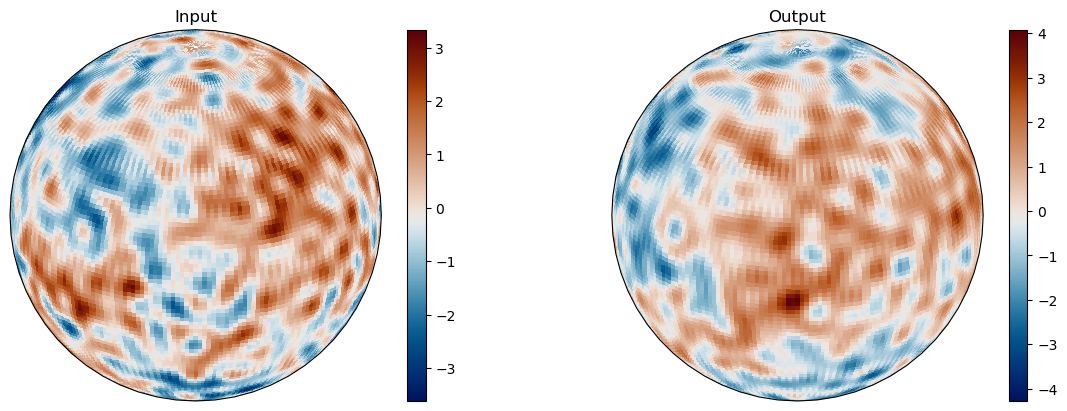

In [127]:
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)
fig, axs = plt.subplots(1,2, figsize = (12,4), subplot_kw={'projection': proj}, layout = "constrained")

# contour data over the map.
im = axs[0].pcolormesh(Lons, Lats, a[0,0], transform=ccrs.PlateCarree(), antialiased = False)
plt.colorbar(im)
axs[0].set_title("Input")

im = axs[1].pcolormesh(Lons, Lats, u[0,0], transform=ccrs.PlateCarree(), antialiased = False)
plt.colorbar(im)
axs[1].set_title("Output")

# Run Model

In [128]:
# Losses and parameters
l2loss = SphericalL2Loss(nlon = nlon, weights = weights.to(device))
energy_score = EnergyScore(type = "spherical", nlon = nlon, weights = weights.to(device))


# Training parameters
epochs = 20
learning_rate = 0.002
dropout_rate = 0.01
max_train = 1000

In [129]:
dropout_model = SFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, projection_channels=64, factorization='dense', dropout = dropout_rate)
dropout_model = dropout_model.to(device)


n_params = count_model_params(dropout_model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 277923 parameters.


In [130]:
optimizer = torch.optim.Adam(dropout_model.parameters(),lr=learning_rate)

In [131]:
train_loss = torch.zeros(epochs)

for ep in range(epochs):
    dropout_model.train()
    t1 = default_timer()
    train_l2 = 0
    for i,sample in enumerate(train_loader):
        a, u = sample
        a = a.to(device)
        u = u[:,0].to(device)

        optimizer.zero_grad()
        out = dropout_model(a)
        
        l2 = l2loss(out, u)
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()
        if i*batch_size >= max_train:
            break

    train_l2 /= n_train
    
    train_loss[ep] = train_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.6f}'.format(ep, t2-t1, train_l2))
print("Fine tuning!")


train_loss = torch.zeros(epochs)
for ep in range(epochs):
    dropout_model.train()
    t1 = default_timer()
    train_l2 = 0
    for i,sample in enumerate(train_loader):
        a, u = sample
        a = a.to(device)
        u = u[:,1].to(device)

        optimizer.zero_grad()
        out = dropout_model(a)
        out = dropout_model(out)
        
        l2 = l2loss(out, u)
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()
        if i*batch_size >= max_train:
            break

    train_l2 /= n_train
    
    train_loss[ep] = train_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.6f}'.format(ep, t2-t1, train_l2))

Epoch-0, Time-6.0483, Train-L2-4.787135
Epoch-1, Time-5.8991, Train-L2-3.293987
Epoch-2, Time-5.9273, Train-L2-2.843073
Epoch-3, Time-5.9100, Train-L2-2.740523
Epoch-4, Time-5.8963, Train-L2-2.703030
Epoch-5, Time-6.1346, Train-L2-2.683065
Epoch-6, Time-5.9300, Train-L2-2.667440
Epoch-7, Time-5.9255, Train-L2-2.658372
Epoch-8, Time-5.9096, Train-L2-2.653092
Epoch-9, Time-5.8970, Train-L2-2.650197
Epoch-10, Time-5.9331, Train-L2-2.646131
Epoch-11, Time-5.9051, Train-L2-2.642246
Epoch-12, Time-5.9037, Train-L2-2.641692
Epoch-13, Time-5.9042, Train-L2-2.640369
Epoch-14, Time-5.9144, Train-L2-2.636835
Epoch-15, Time-5.8967, Train-L2-2.634326
Epoch-16, Time-5.9045, Train-L2-2.634132
Epoch-17, Time-5.9183, Train-L2-2.632170
Epoch-18, Time-5.9646, Train-L2-2.630242
Epoch-19, Time-5.9065, Train-L2-2.629374
Fine tuning!
Epoch-0, Time-9.8063, Train-L2-4.121497
Epoch-1, Time-9.7988, Train-L2-3.439051
Epoch-2, Time-9.8058, Train-L2-3.200303
Epoch-3, Time-9.8245, Train-L2-3.107048
Epoch-4, Time-9.8

# MCDropout

In [132]:
""" Prediction """
mse_dropout = 0
es_dropout = 0

with torch.no_grad():    
    index = 0
    for sample in test_loader:
        a, u = sample
        a = a.to(device)
        u = u.to(device)
        # Autoregressive steps
        dropout_model.eval()
        for _ in range(eval_horizon-1):
            a = dropout_model(a)
        
        dropout_model.train()
        out = generate_mcd_samples(dropout_model, a, u.shape, n_samples=n_samples)
        mse_dropout += l2loss(out.mean(axis = -1), u).item() / n_test
        es_dropout += energy_score(out, u).item() / n_test


print('MSE:', mse_dropout)
print('ES:', es_dropout)

MSE: 3.053205146395035
ES: 2.8888172050202785


# Laplace approximation

In [133]:
la_model = LA_Wrapper(dropout_model, n_samples=n_samples, method = "last_layer", hessian_structure = "full", optimize = True)
la_model.fit(test_loader)

In [134]:
""" Prediction """
mse_la = 0
es_la = 0
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        a, u = sample
        a = a.to(device)
        u = u.to(device)
        # Autoregressive steps
        for _ in range(eval_horizon-1):
            a = la_model.model(a)        
        out = la_model.predictive_samples(a)
        mse_la += l2loss(out.mean(axis = -1), u).item() / n_test
        es_la += energy_score(out, u).item() / n_test


print('MSE:', mse_la)
print('ES:', es_la)

MSE: 3.063479709352308
ES: 2.3571615168226456


# PFNO

In [135]:
# hidden_model = SFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, projection_channels=64, factorization='dense', dropout = dropout_rate)
# hidden_model = hidden_model.to(device)
pfno_model = PSFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, projection_channels=64, factorization='dense', dropout = 0.01, n_samples = 3)
pfno_model.to(device)


n_params = count_model_params(pfno_model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()

# pfno_model = PNO_Wrapper(hidden_model, n_samples = 3)
# pfno_model.to(device)

optimizer = torch.optim.Adam(pfno_model.parameters(),lr=learning_rate)


Our model has 280230 parameters.


In [136]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    pfno_model.eval()
    t1 = default_timer()
    train_l2 = 0
    for i,sample in enumerate(train_loader):
        a, u = sample
        a = a.to(device)
        u = u[:,0].to(device)
        optimizer.zero_grad()
        out = pfno_model(a)
        
        l2 = energy_score(out,u)
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()
        if i*batch_size >= max_train:
            break

    train_l2 /= n_train
    
    train_loss[ep] = train_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.4f}'.format(ep, t2-t1, train_l2))
print("Fine tuning!")

for ep in range(epochs):
    pfno_model.eval()
    t1 = default_timer()
    train_l2 = 0
    for i,sample in enumerate(train_loader):
        a, u = sample
        a = a.to(device)
        u = u[:,1].to(device)
        optimizer.zero_grad()
        out = pfno_model(a, n_samples = 10)
        out = pfno_model(out.mean(axis = -1))
        
        l2 = energy_score(out,u)
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()
        if i*batch_size >= max_train:
            break

    train_l2 /= n_train
    
    train_loss[ep] = train_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.4f}'.format(ep, t2-t1, train_l2))

Epoch-0, Time-10.1980, Train-L2-3.4532
Epoch-1, Time-10.2699, Train-L2-2.2866
Epoch-2, Time-10.2669, Train-L2-1.9783
Epoch-3, Time-11.6997, Train-L2-1.9219
Epoch-4, Time-10.1674, Train-L2-1.8793
Epoch-5, Time-10.1900, Train-L2-1.8654
Epoch-6, Time-10.2003, Train-L2-1.8563
Epoch-7, Time-10.2327, Train-L2-1.8546
Epoch-8, Time-10.2106, Train-L2-1.8562
Epoch-9, Time-10.2959, Train-L2-1.8523
Epoch-10, Time-10.2228, Train-L2-1.8513
Epoch-11, Time-10.3509, Train-L2-1.8499
Epoch-12, Time-10.1992, Train-L2-1.8519
Epoch-13, Time-10.3153, Train-L2-1.8510
Epoch-14, Time-10.2018, Train-L2-1.8500
Epoch-15, Time-10.2076, Train-L2-1.8496
Epoch-16, Time-10.2488, Train-L2-1.8483
Epoch-17, Time-10.2970, Train-L2-1.8484
Epoch-18, Time-10.1922, Train-L2-1.8494
Epoch-19, Time-10.1935, Train-L2-1.8490
Fine tuning!
Epoch-0, Time-33.0424, Train-L2-2.7298
Epoch-1, Time-33.0565, Train-L2-2.3557
Epoch-2, Time-33.2389, Train-L2-2.2624
Epoch-3, Time-33.0869, Train-L2-2.2419
Epoch-4, Time-33.0133, Train-L2-2.1598
Ep

KeyboardInterrupt: 

In [137]:
pfno_model.eval()
""" Prediction """
mse_pfno = 0
es_pfno = 0
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        a, u = sample
        a = a.to(device)
        u = u.to(device)

        # Autoregressive steps
        for _ in range(eval_horizon-1):
            a = pfno_model(a, n_samples = 10)
            a = a.mean(axis = -1)

        out = pfno_model(a, n_samples = n_samples)
        mse_pfno += l2loss(out.mean(axis = -1), u).item() / n_test
        es_pfno += energy_score(out, u).item() / n_test


print('MSE:', mse_pfno)
print('ES:', es_pfno)

MSE: 3.107848142036347
ES: 2.177664283439173


# Compare Metrics

In [138]:
print(f"Dropout \nMSE: {mse_dropout} \t ES: {es_dropout}")
print(f"LA \nMSE: {mse_la} \t ES: {es_la}")
print(f"PFNO \nMSE: {mse_pfno} \t ES: {es_pfno}")

Dropout 
MSE: 3.053205146395035 	 ES: 2.8888172050202785
LA 
MSE: 3.063479709352308 	 ES: 2.3571615168226456
PFNO 
MSE: 3.107848142036347 	 ES: 2.177664283439173


# Visualizations

In [139]:
n_samples = 100

In [140]:
sample = np.random.randint(0,n_test)

dropout_model.eval()
""" Prediction """
truth = []
pred_pfno = []
pred_dropout = []
pred_la = []

with torch.no_grad():
    a,u = test_data.__getitem__(sample)
    a = a.to(device).unsqueeze(0)
    u = u.to(device).unsqueeze(0)
    # Dropout
    out = dropout_model(a)
    for _ in range(1,eval_horizon-1):
        out = dropout_model(out)
    dropout_model.train()
    dropout_pred = generate_mcd_samples(dropout_model, out, u.shape, n_samples=n_samples)

    # LA
    out = la_model.model(a)
    for _ in range(1,eval_horizon-1):
        out = la_model.model(out)
    la_pred = la_model.predictive_samples(out)

    # PFNO
    out = pfno_model(a)
    for _ in range(1,eval_horizon-1):
        out = pfno_model(out.mean(axis = -1))
    pfno_pred = pfno_model(out.mean(axis = -1), n_samples = n_samples)
        

    pred_dropout.append( dropout_pred )
    pred_pfno.append( pfno_pred )
    pred_la.append( la_pred )
    truth.append( u )


pred_pfno = torch.cat(pred_pfno, dim = 0).cpu().numpy()
pred_dropout = torch.cat(pred_dropout, dim = 0).cpu().numpy()
pred_la = torch.cat(pred_la, dim = 0).cpu().numpy()
truth = torch.cat(truth, dim = 0).cpu().numpy()

In [141]:
idx = 0
preds = [pred_dropout, pred_la, pred_pfno]

Text(0, 0.5, 'PFNO')

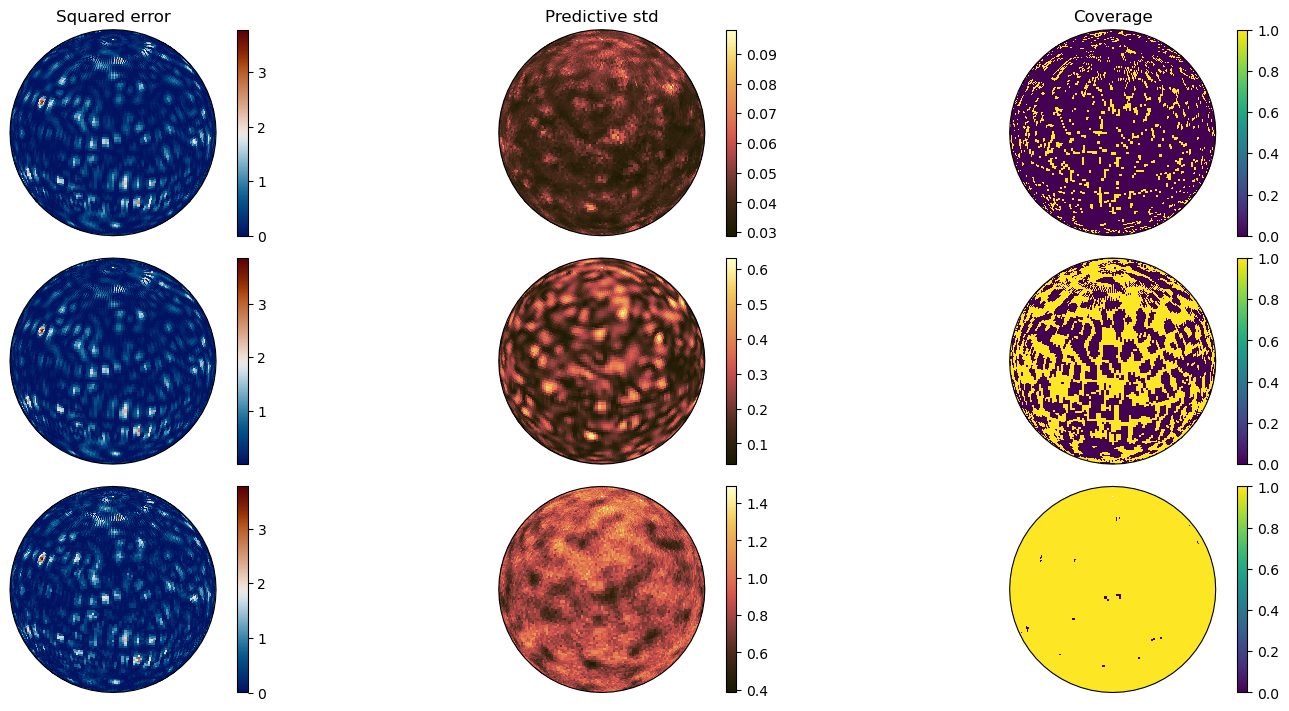

In [142]:
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)
fig, axs = plt.subplots(3,3, figsize = (15,7), subplot_kw={'projection': proj}, layout = "constrained")
for i, pred in enumerate(preds):
    # im = axs[i,0].pcolormesh(Lons, Lats, truth[idx,0], transform=ccrs.PlateCarree(), antialiased = False)
    # plt.colorbar(im)

    im = axs[i,0].pcolormesh(Lons, Lats, np.power(pred[idx,0].mean(axis = -1)-truth[idx,0],2), transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    im = axs[i,1].pcolormesh(Lons, Lats, pred[idx,0].std(axis = -1), transform=ccrs.PlateCarree(), antialiased = False, cmap = "cmc.lajolla")
    plt.colorbar(im)

    # Calculate coverage
    q_lower = np.quantile(pred[idx,0],alpha/2, axis = -1)
    q_upper = np.quantile(pred[idx,0],1-alpha/2, axis = -1)
    coverage = (truth[idx,0]>q_lower) & (truth[idx,0]<q_upper)

    im = axs[i,2].pcolormesh(Lons, Lats, coverage, transform=ccrs.PlateCarree(), antialiased = False, cmap = "viridis")
    plt.colorbar(im)


axs[0,0].set_title("Squared error")
axs[0,1].set_title("Predictive std")
axs[0,2].set_title("Coverage")

axs[0,0].set_ylabel("MCDropout")
axs[1,0].set_ylabel("LA")
axs[2,0].set_ylabel("PFNO")

Text(0, 0.5, 'PFNO')

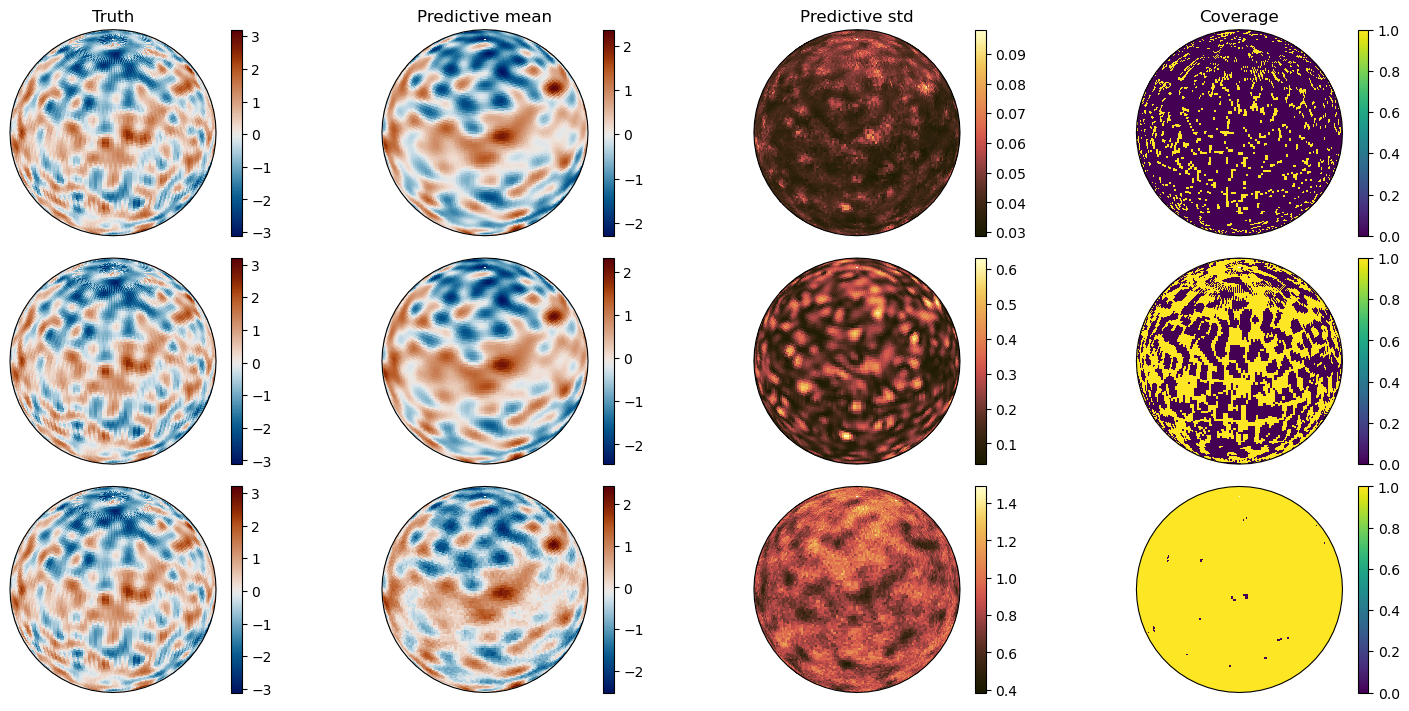

In [143]:
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)
fig, axs = plt.subplots(3,4, figsize = (15,7), subplot_kw={'projection': proj}, layout = "constrained")
for i, pred in enumerate(preds):
    im = axs[i,0].pcolormesh(Lons, Lats, truth[idx,0], transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    im = axs[i,1].pcolormesh(Lons, Lats, pred[idx,0].mean(axis = -1), transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    im = axs[i,2].pcolormesh(Lons, Lats, pred[idx,0].std(axis = -1), transform=ccrs.PlateCarree(), antialiased = False, cmap = "cmc.lajolla")
    plt.colorbar(im)

    # Calculate coverage
    q_lower = np.quantile(pred[idx,0],alpha/2, axis = -1)
    q_upper = np.quantile(pred[idx,0],1-alpha/2, axis = -1)
    coverage = (truth[idx,0]>q_lower) & (truth[idx,0]<q_upper)

    im = axs[i,3].pcolormesh(Lons, Lats, coverage, transform=ccrs.PlateCarree(), antialiased = False, cmap = "viridis")
    plt.colorbar(im)


axs[0,0].set_title("Truth")
axs[0,1].set_title("Predictive mean")    
axs[0,2].set_title("Predictive std")
axs[0,3].set_title("Coverage")

axs[0,0].set_ylabel("MCDropout")
axs[1,0].set_ylabel("LA")
axs[2,0].set_ylabel("PFNO")

# Plot prediction history

In [144]:
sample = np.random.randint(0,n_test)

eval_data = SSWEDataset(data_dir, test = True, pred_horizon = eval_horizon, return_all = True)

dropout_model.eval()
""" Prediction """
truth = []
pred_pfno = []
pred_dropout = []

with torch.no_grad():
    a,u = eval_data.__getitem__(sample)
    a = a.to(device).unsqueeze(0)
    u = u.to(device).unsqueeze(0)
    # Dropout
    out = dropout_model(a)
    pred_dropout.append( out )
    for _ in range(1,eval_horizon):
        out = dropout_model(out)
        pred_dropout.append( out )

    # PFNO
    out = pfno_model(a, n_samples = n_samples)
    out = out.mean(axis = -1)
    pred_pfno.append( out )

    for _ in range(1,eval_horizon):        
        out = pfno_model(out, n_samples = n_samples)
        out = out.mean(axis = -1)
        pred_pfno.append( out )

truth = u.squeeze().cpu().numpy()
inp = a.squeeze().cpu().numpy()
pred_pfno = torch.cat(pred_pfno, dim = 0).cpu().numpy()
pred_dropout = torch.cat(pred_dropout, dim = 0).cpu().numpy()

Text(0, 0.5, 'PFNO')

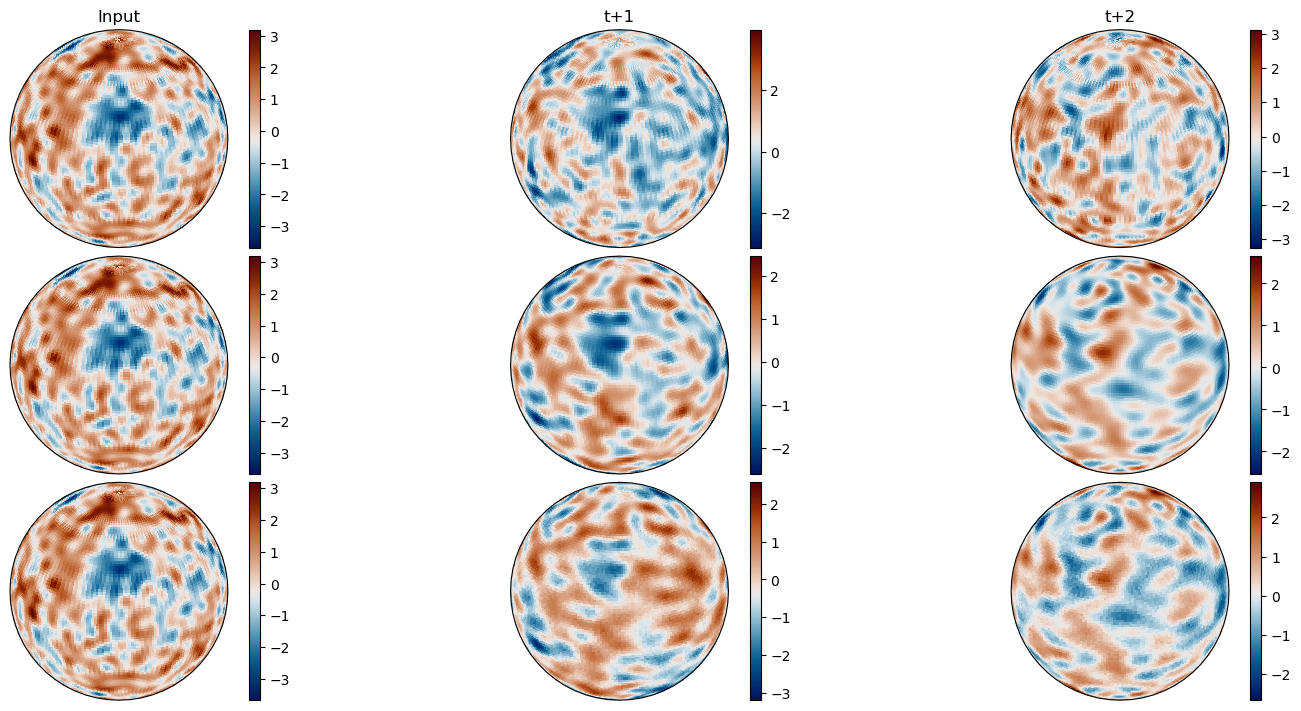

In [145]:
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)
fig, axs = plt.subplots(3,(eval_horizon+1), figsize = (15,7), subplot_kw={'projection': proj}, layout = "constrained")
for i in range(3):
    im = axs[i,0].pcolormesh(Lons, Lats, inp[0], transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)
    axs[0,0].set_title("Input")

for i in range(eval_horizon):
    im = axs[0,i+1].pcolormesh(Lons, Lats, truth[i,0], transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    im = axs[1,i+1].pcolormesh(Lons, Lats, pred_dropout[i,0], transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    im = axs[2,i+1].pcolormesh(Lons, Lats, pred_pfno[i,0], transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    axs[0,i+1].set_title(f"t+{i+1}")


axs[0,0].set_ylabel("Truth")
axs[1,0].set_ylabel("Dropout")
axs[2,0].set_ylabel("PFNO")